In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [2]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/split_stage_data_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/split_stage_data_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY

In [3]:
norm_fn = norm_min1_to_1
train_data = MultiXArrayDataset(data_paths, participants_to_keep=splits[0], normalization_fn=norm_fn)
norm_vars = get_norm_vars_from_global_statistics(train_data.statistics, norm_fn)
class_weights = train_data.statistics['class_weights']

In [4]:
test_data = MultiXArrayDataset(data_paths, participants_to_keep=splits[1], normalization_fn=norm_fn, norm_vars=norm_vars)
val_data = MultiXArrayDataset(data_paths, participants_to_keep=splits[2], normalization_fn=norm_fn, norm_vars=norm_vars)

In [8]:
# data_path = DATA_PATH / "sat2/split_stage_data_100hz.nc"
# # data_path = Path("../data/ar/split_stage_data.nc")

# dataset = xr.load_dataset(data_path)
# dataset = dataset.where(dataset.event_name.str.contains("accuracy"), drop=True)
# shape_topological = False
# # truncate_sample = 50
# train_data, val_data, test_data = split_data_on_participants(
#     dataset, 60, norm_min1_to_1
# )
# train_data = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# val_data = SAT1Dataset(val_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# test_data = SAT1Dataset(test_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)

['S12', 'S1', 'S18', 'S9', 'S6', 'S11', 'S3', 'S10']


In [ ]:
model = SAT1GRU(
    64, 5
)

train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=6,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.01,
    lr=0.001,
    do_spectral_decoupling=False,
    use_class_weights=True,
    class_weights=None
)

In [1]:
# model = SAT1GRU(30, len(train_data.label_lookup))
model = MambaModel(256, 19, 5, 6, global_pool=True, dropout=0.1)
# 2 workers, ~18 b/s
# 4 workers, ~35 b/s
# 8 workers, ~48 b/s
# 12 workers, ~48 b/s
train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=6,
    batch_size=64,
    labels=SAT_CLASSES_ACCURACY,
    lr=0.0001,
    # label_smoothing=0.0001,
    # weight_decay=0.01,
    do_spectral_decoupling=False,
    use_class_weights=True,
    class_weights=class_weights,
)

NameError: name 'MambaModel' is not defined

In [ ]:
# model = TSTransformerEncoderClassiregressor(
#     feat_dim = len(train_data.channels),
#     max_len = len(train_data.samples),
#     d_model=512,
#     n_heads=16,
#     num_layers=6,
#     dim_feedforward=2048,
#     num_classes=len(train_data.labels),
# )
model = TSTransformerEncoderClassiregressor(
    feat_dim=len(train_data.channels),
    max_len=len(train_data.samples),
    d_model=256,
    n_heads=8,
    num_layers=6,
    dim_feedforward=2048,
    num_classes=len(train_data.labels),
)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

In [10]:

model = TransformerModel(19, 6, 128, 2, 250, len(SAT_CLASSES_ACCURACY))
train_and_test(
    model,
    train_data,
    test_data,
    val_data,
    logs_path=Path("../logs/"),
    workers=6,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.01,
    do_spectral_decoupling=False,
    use_class_weights=True,
    class_weights=class_weights
)

RuntimeError: The expanded size of the tensor (9) must match the existing size (10) at non-singleton dimension 1.  Target sizes: [250, 9].  Tensor sizes: [250, 10]

In [ ]:
model = SAT1Base(len(test_data.labels))

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    label_smoothing=0.0001,
    weight_decay=0.001,
    do_spectral_decoupling=False,
)

In [ ]:
model = SAT1GRU(
    len(train_data_sat1.channels),
    len(train_data_sat1.samples),
    len(train_data_sat1.labels),
)

train_and_test(
    model,
    train_dataset_sat1,
    test_dataset_sat1,
    val_dataset_sat1,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY,
)

In [ ]:
chk_path = Path("../models/gru100/checkpoint.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "n_channels": len(dataset_sat1.channels),
    "n_samples": len(dataset_sat1.samples),
    "n_classes": len(dataset_sat1.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [18]:
test_loader = DataLoader(
    test_data, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [22]:
test_loader = DataLoader(
    train_dataset_sat1, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

0.907750737094598


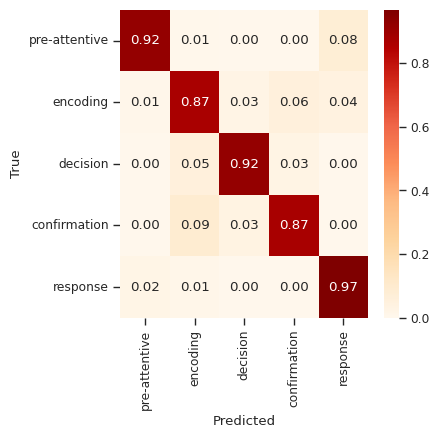

In [19]:
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY)